In [1]:
import re
import os
import sys
import glob
import argparse
import numpy as np
import xarray as xr
import pandas as pd
import scipy.linalg as LA
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.colors as mcolors


In [22]:
from scipy import interpolate

ZZ_vec = np.loadtxt('../../include/fitpack/test/data/x_vec.dat')
MB_vec = np.loadtxt('../../include/fitpack/test/data/y_vec.dat')

XX_vec = np.loadtxt('../../input_data/klut-b_surf.dat')[:,0]
Zs_vec = np.loadtxt('../../input_data/klut-b_surf.dat')[:,1]
Zb_vec = np.loadtxt('../../input_data/klut-b_bed.dat' )[:,1]

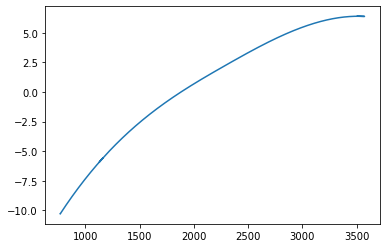

In [41]:
tck = interpolate.splrep(ZZ_vec, MB_vec)
MB_klut = interpolate.splev(Zs_vec, tck) + 2.0

plt.plot(Zs_vec,MB_klut)

In [42]:
idx = int(np.median(np.argpartition(np.abs(MB_klut), 5)[:5]))

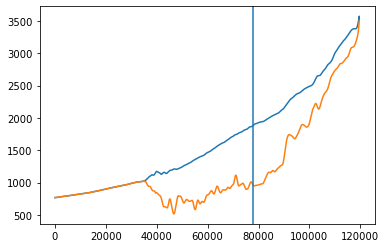

In [43]:
plt.plot(XX_vec, Zs_vec)
plt.plot(XX_vec, Zb_vec)

plt.axvline(XX_vec[idx])

In [98]:
# Glob the file paths and return list of files
files = sorted(glob.glob("result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_*_OFF.nc"))

# Raise error if glob didn't work
if not files:
    raise OSError('value passed for "src_path" is invalid')

# Sorting isn't guaranted to work corretly, so if pattern is matched
# do special sorting ensure it's done correctly
regex = re.search('MB_-*\d*\d\.\d*\d_OFF', files[0])
if regex:
    files.sort(key = lambda x: float(x.split('MB_')[-1].split('_OFF')[0]),
               reverse = True)

# Create array of mass balance values used in spin-up
MB, dx = np.linspace(float(0.0),
                     float(2.0),
                     len(files),
                     retstep=True)

# Check the the MB stride is the same as the stride that was specified
if not np.isclose(dx, 0.1):
    raise OSError('MB stride passed does not match that of files found')

# Make an empty list to store the read in .nc files
xarrays = []

# Iterate over each .nc file and read in with xarray
for file in files:
    print(file)
    with xr.open_dataset(file) as src:
            # correct for minimum ice thickness
            src["height"] = xr.where(src.height <= 10, 0, src.height)
            # apply sigma coordinate transform for vertical coordinate
            src["z_s"]     = src.zbed + src.Z * src.height
            # Calculate the magnitude of the velocity vectors
            src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)

    xarrays.append(src)

# Concatenate the .nc files via their mass balance offset
mf_dataset = xr.concat(xarrays,
                       pd.Index(data = MB, name='Delta_MB'))

result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_0.0_OFF.nc
result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_-0.1_OFF.nc
result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_-0.2_OFF.nc
result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_-0.3_OFF.nc
result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_-0.4_OFF.nc
result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_-0.5_OFF.nc
result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_-0.6_OFF.nc
result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_-0.7_OFF.nc
result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_-0.8_OFF.nc
result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_-0.9_OFF.nc
result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_-1.0_OFF.nc
result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_-1.1_OFF.nc
result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_-1.2_OFF.nc
result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_-1.3_OFF.nc
result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_-1.4_OFF.nc
result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_-1.5_OFF.nc
result/glc1-a/nc/glc1-a_1000a_dt_1_dx_200_MB_-1.6_OFF.nc
result/glc1-a/nc/glc1-a_1000a_dt

In [99]:
def make_colorbar(mf_dataset):
    #---------------------------------------------------------------------------
    # For Seting up the colorbar:
    #    - http://csc.ucdavis.edu/~jmahoney/matplotlib-tips.html
    #---------------------------------------------------------------------------
    cmap = cm.plasma
    norm = mcolors.Normalize(vmin=np.min(mf_dataset.Delta_MB.values),
                             vmax=np.max(mf_dataset.Delta_MB.values))

    s_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    s_map.set_array(mf_dataset.Delta_MB.values)

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (mf_dataset.Delta_MB[1] - mf_dataset.Delta_MB[0]) / 2.0
    bounds   = np.linspace(mf_dataset.Delta_MB[0]   - halfdist,
                           mf_dataset.Delta_MB[-1]  + halfdist,
                           len(mf_dataset.Delta_MB) + 1)

    return cmap, norm, s_map, bounds

In [100]:
np.min(mf_dataset.Delta_MB.values)

0.0

0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001
1.0


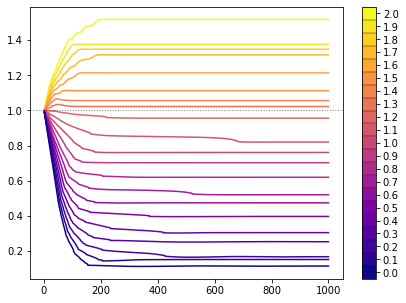

In [102]:
# Make a volume xarray
Vol = mf_dataset.height.isel(coord_2=-1).integrate("coord_1") /\
      mf_dataset.height.isel(coord_2=-1).isel(t=0).integrate("coord_1")

# Make a colormap and all the associated var names
cmap, norm, s_map, bounds = make_colorbar(mf_dataset)


fig, ax = plt.subplots(figsize=(7, 5))

for delta_mb in Vol.Delta_MB.values:
    print(norm(delta_mb))
    color = cmap(1-norm(delta_mb))
    ax.plot(Vol.t[1:], Vol.sel(Delta_MB=delta_mb)[1:], color=color)

ax.axhline(1.0,c='k',ls=':',lw=1, alpha=0.5)

cbar = fig.colorbar(s_map,
                    spacing='proportional',
                    ticks=mf_dataset.Delta_MB,
                    ax=ax,
                    boundaries=bounds,
                    drawedges=True,
                    format='%2.{}f'.format(1))

In [75]:
np.linspace(mf_dataset.Delta_MB.values.min(),
            mf_dataset.Delta_MB.values.max(),
            mf_dataset.Delta_MB.size)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [76]:
s_map.get_array()

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])